In [84]:
import os
import pandas as pd

# setting the dataset directory 
data_dir = r"D:\Masters\Semester 3\Research project\lung_colon_image_set\Parkinson"

In [86]:
# Loading the data by extractring the src directories
file_paths = []
labels = []
splits = []   

## The original dataset is already splitted as train and test directories
splits_folders = {"trainDatasets": "train", "testDatasets": "test"}

for split_folder, split_name in splits_folders.items():
    split_path = os.path.join(data_dir, split_folder)
    
    ## classes (AD, CONTROL, PD)
    for label_name in os.listdir(split_path):
        class_path = os.path.join(split_path, label_name)

        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                if file.lower().endswith((".png", ".jpg", ".jpeg")):   
                    file_paths.append(os.path.join(class_path, file))
                    labels.append(label_name)
                    splits.append(split_name)

# Create DataFrame with columns of 'file paths', 'labels' and the folder name(is it train or test folder)
df = pd.DataFrame({
    "file_paths": file_paths,
    "labels": labels,
    "split": splits
})

# Map labels to numeric (where 0 - AD, 1- Control, 2- PD)
label_map = {label: idx for idx, label in enumerate(df["labels"].unique())}
df["labels_numeric"] = df["labels"].map(label_map)

In [88]:
print(df.head())
print(f"Total images: {len(df)}")
print("Class distribution:\n", df.groupby(["split", "labels"]).size())

                                          file_paths labels  split  \
0  D:\Masters\Semester 3\Research project\lung_co...     AD  train   
1  D:\Masters\Semester 3\Research project\lung_co...     AD  train   
2  D:\Masters\Semester 3\Research project\lung_co...     AD  train   
3  D:\Masters\Semester 3\Research project\lung_co...     AD  train   
4  D:\Masters\Semester 3\Research project\lung_co...     AD  train   

   labels_numeric  
0               0  
1               0  
2               0  
3               0  
4               0  
Total images: 17034
Class distribution:
 split  labels 
test   AD          639
       CONTROL     662
       PD           61
train  AD         5122
       CONTROL    6020
       PD         4530
dtype: int64


In [ ]:
#Data Preprocessing
import cv2
import numpy as np

def load_images(df, img_size=(128,128)):
    X, y = [], []

    for path, label in zip(df["file_paths"], df["labels_numeric"]):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)   # converting the original rgb into grayscale
        img = cv2.resize(img, img_size)                # resize
        img = img.astype("float32") / 255.0            # normalizing the data
        
        X.append(img)
        y.append(label)
    
    X = np.array(X)
    y = np.array(y)
    
    # reshape to (N, H, W, 1) for CNN input
    X = np.expand_dims(X, axis=-1)
    
    return X, y

# loading train and test separately
train_df = df[df["split"] == "train"]
test_df  = df[df["split"] == "test"]

X_train, y_train = load_images(train_df, img_size=(128,128)) #image size of 128x128 was selected
X_test, y_test   = load_images(test_df, img_size=(128,128))

In [22]:
#checking the class counts in the training data
from collections import Counter
print("Original training class counts:", Counter(y_train))

Original training class counts: Counter({1: 6020, 0: 5122, 2: 4530})


In [24]:
#Splitting the train data into train_final(80%) and X_val(20%). 
from sklearn.model_selection import train_test_split
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

#Checking the class imbalance
print("Training shape:", X_train_final.shape, "Validation shape:", X_val.shape)
print("Training class counts before augmentation:", Counter(y_train_final))

Training shape: (12537, 128, 128, 1) Validation shape: (3135, 128, 128, 1)
Training class counts before augmentation: Counter({1: 4816, 0: 4097, 2: 3624})


In [26]:
# Augment minority class in training subset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

minority_class = 2  # PD (change according to your label_map)
minority_idx = np.where(y_train_final == minority_class)[0]

# how many to generate to balance classes
counts = Counter(y_train_final)
max_class_count = max(counts.values())
num_to_generate = max_class_count - counts[minority_class]
print(f"Generating {num_to_generate} augmented images for class {minority_class}")

# Setting up augmentation
datagen = ImageDataGenerator(shear_range=0.1, zoom_range=0.1, horizontal_flip=True)

aug_images, aug_labels = [], []

for idx in minority_idx:
    img = X_train_final[idx]
    img = np.expand_dims(img, axis=0)  # batch dim
    for batch in datagen.flow(img, batch_size=1):
        aug_images.append(batch[0])
        aug_labels.append(minority_class)
        if len(aug_images) >= num_to_generate:
            break
    if len(aug_images) >= num_to_generate:
        break

# Append augmented images to training set
X_train_final = np.concatenate([X_train_final, np.array(aug_images)], axis=0)
y_train_final = np.concatenate([y_train_final, np.array(aug_labels)], axis=0)

print("Training class counts after augmentation:", Counter(y_train_final))

Generating 1192 augmented images for class 2
Training class counts after augmentation: Counter({2: 4816, 1: 4816, 0: 4097})


In [37]:
#CNN
import numpy as np
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import initializers #to balnce the weights
from keras.regularizers import l1,l2 # to minimize the overfitting using three types of regression : lasso (l2), ridge(l1)
from keras.layers import Input

# Check training data shapes
print("Training shape:", X_train_final.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


# Baseline CNN
num_classes = 3
input_shape = (128, 128, 1)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same',
           kernel_initializer='he_normal', kernel_regularizer=l2(0.01),
           input_shape=input_shape),
    MaxPooling2D((2,2), padding='same'),
    
    Conv2D(64, (3,3), activation='relu', padding='same',
           kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2,2), padding='same'),
    
    Conv2D(128, (3,3), activation='relu', padding='same',
           kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2,2), padding='same'),
    
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


# Compiling the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # labels are integers
    metrics=['accuracy']
)


# Training the model
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=10,
    shuffle=True
)



Training shape: (13729, 128, 128, 1)
Validation shape: (3135, 128, 128, 1)
Test shape: (1362, 128, 128, 1)


C:\Users\VICTUS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.6681 - loss: 5.2198 - val_accuracy: 0.7254 - val_loss: 2.0897
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.7392 - loss: 1.8365 - val_accuracy: 0.7356 - val_loss: 1.3874
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.7391 - loss: 1.2801 - val_accuracy: 0.7458 - val_loss: 1.0649
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.7524 - loss: 0.9828 - val_accuracy: 0.7547 - val_loss: 0.8752
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.7527 - loss: 0.8242 - val_accuracy: 0.7550 - val_loss: 0.7645
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.7594 - loss: 0.7251 - val_accuracy: 0.7640 - val_loss: 0.6859
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - accuracy: 0.7621 - loss: 0.6614 - val_accuracy: 0.7301 - val_loss: 0.6547
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.7610 - loss: 0.6261 - val_accu

In [37]:
import numpy as np
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import initializers #to balnce the weights
from keras.regularizers import l1,l2 # to minimize the overfitting using three types of regression
from keras.layers import Input

# Check training data shapes

print("Training shape:", X_train_final.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


# Simple CNN

num_classes = 3
input_shape = (128, 128, 1)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same',
           kernel_initializer='he_normal', kernel_regularizer=l2(0.01),
           input_shape=input_shape),
    MaxPooling2D((2,2), padding='same'),
    
    Conv2D(64, (3,3), activation='relu', padding='same',
           kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2,2), padding='same'),
    
    Conv2D(128, (3,3), activation='relu', padding='same',
           kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2,2), padding='same'),
    
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])



#  Compiling the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # labels are integers
    metrics=['accuracy']
)


# Train the model
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=10,
    shuffle=True
)



Training shape: (13729, 128, 128, 1)
Validation shape: (3135, 128, 128, 1)
Test shape: (1362, 128, 128, 1)


C:\Users\VICTUS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.6681 - loss: 5.2198 - val_accuracy: 0.7254 - val_loss: 2.0897
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.7392 - loss: 1.8365 - val_accuracy: 0.7356 - val_loss: 1.3874
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.7391 - loss: 1.2801 - val_accuracy: 0.7458 - val_loss: 1.0649
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.7524 - loss: 0.9828 - val_accuracy: 0.7547 - val_loss: 0.8752
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.7527 - loss: 0.8242 - val_accuracy: 0.7550 - val_loss: 0.7645
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.7594 - loss: 0.7251 - val_accuracy: 0.7640 - val_loss: 0.6859
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - accuracy: 0.7621 - loss: 0.6614 - val_accuracy: 0.7301 - val_loss: 0.6547
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.7610 - loss: 0.6261 - val_accu

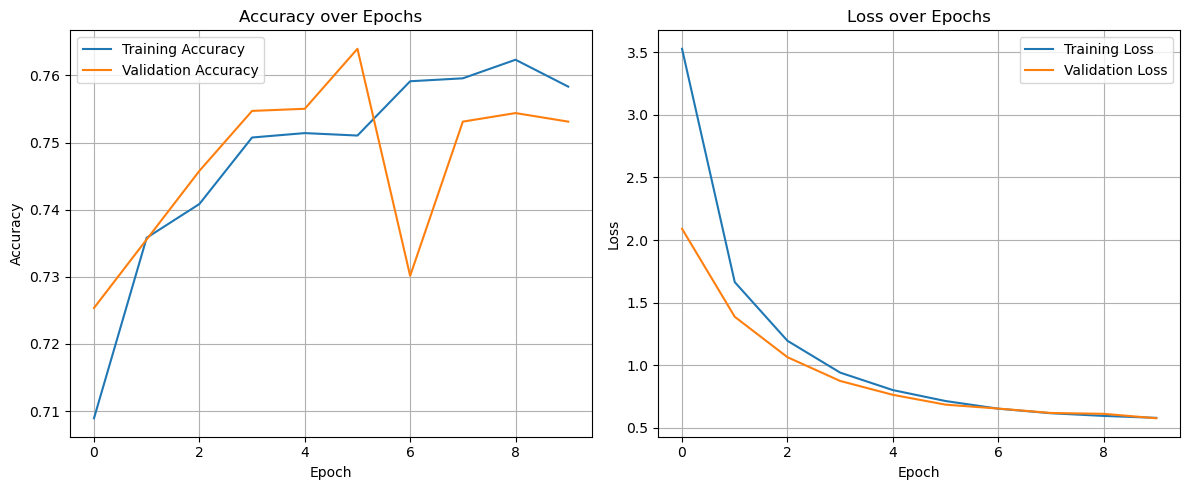

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [47]:
#Fine tuned 2D CNN - Deep CNN
num_classes = 3
input_shape = (128, 128, 1)

model2 = Sequential([
    Conv2D(64, (3,3), activation='relu', padding='same',
           kernel_initializer='he_normal', kernel_regularizer=l2(0.01),
           input_shape=input_shape),
    MaxPooling2D((2,2), padding='same'), 
    Conv2D(128, (3,3), activation='relu', padding='same',
           kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2,2), padding='same'),  
    Conv2D(128, (3,3), activation='relu', padding='same',
           kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2,2), padding='same'), 
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


# Compile the model
model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # labels are integers
    metrics=['accuracy']
)

# Train the model

history2 = model2.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=15,
    shuffle=True
)


C:\Users\VICTUS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 703s 3s/step - accuracy: 0.6610 - loss: 7.3053 - val_accuracy: 0.7483 - val_loss: 2.4025
Epoch 2/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 685s 3s/step - accuracy: 0.7642 - loss: 2.0360 - val_accuracy: 0.7608 - val_loss: 1.3386
Epoch 3/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 688s 3s/step - accuracy: 0.7885 - loss: 1.1826 - val_accuracy: 0.7518 - val_loss: 0.9485
Epoch 4/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 692s 3s/step - accuracy: 0.7821 - loss: 0.8589 - val_accuracy: 0.7659 - val_loss: 0.7504
Epoch 5/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 689s 3s/step - accuracy: 0.7988 - loss: 0.6943 - val_accuracy: 0.7754 - val_loss: 0.6503
Epoch 6/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 718s 3s/step - accuracy: 0.8091 - loss: 0.5991 - val_accuracy: 0.8083 - val_loss: 0.5765
Epoch 7/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 1035s 5s/step - accuracy: 0.8109 - loss: 0.5620 - val_accuracy: 0.7997 - val_loss: 0.5477
Epoch 8/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 1203s 6s/step - accuracy: 0.8348 - loss: 0.5070 - val_ac

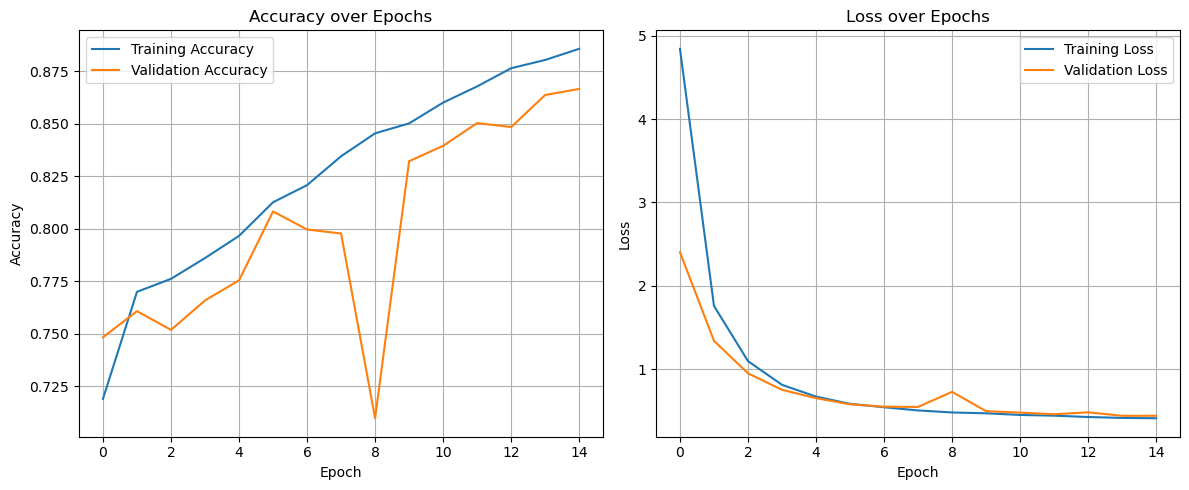

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

ResNet50 

In [88]:
#ResNet50 model 1 
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

num_classes = 3
img_size = (128, 128, 3)   # ResNet expects 3 channels


# Convert grayscale → RGB (for ResNet input)
X_train_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_train_final))
X_val_rgb   = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_val))
X_test_rgb  = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_test))

print("Converted train shape:", X_train_rgb.shape)


# Load ResNet50 backbone without top
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=img_size
)

#  Add minimal classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)  # flatten feature maps
outputs = Dense(num_classes, activation='softmax')(x)

#  Build model
model4 = Model(inputs=base_model.input, outputs=outputs)

#  Freeze backbone layers initially
for layer in base_model.layers:
    layer.trainable = False

# Compile
model4.compile(
    optimizer="Adam",
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#  Train head first
history_head = model4.fit(
    X_train_rgb, y_train_final,
    validation_data=(X_val_rgb, y_val),
    batch_size=64,
    epochs=10,
    shuffle=True
)

Converted train shape: (13729, 128, 128, 3)
Epoch 1/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 540s 2s/step - accuracy: 0.5530 - loss: 1.0435 - val_accuracy: 0.6794 - val_loss: 0.8526
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 619s 3s/step - accuracy: 0.6992 - loss: 0.7925 - val_accuracy: 0.6922 - val_loss: 0.7436
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 617s 3s/step - accuracy: 0.7097 - loss: 0.7052 - val_accuracy: 0.6992 - val_loss: 0.6958
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 599s 3s/step - accuracy: 0.7211 - loss: 0.6511 - val_accuracy: 0.7002 - val_loss: 0.6647
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 542s 3s/step - accuracy: 0.7309 - loss: 0.6223 - val_accuracy: 0.7027 - val_loss: 0.6493
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 562s 3s/step - accuracy: 0.7336 - loss: 0.6000 - val_accuracy: 0.6998 - val_loss: 0.6310
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 601s 3s/step - accuracy: 0.7294 - loss: 0.5923 - val_accuracy: 0.7024 - val_loss: 0.6261
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 604s 3s/step 

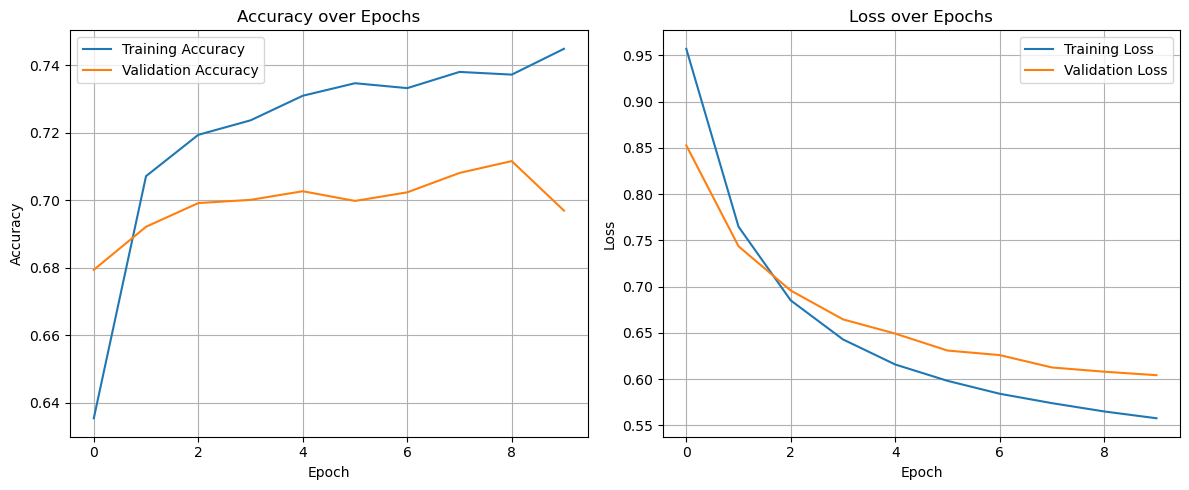

In [90]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_head.history['accuracy'], label='Training Accuracy')
plt.plot(history_head.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_head.history['loss'], label='Training Loss')
plt.plot(history_head.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [98]:
#ResNet50 model 2
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

num_classes = 3
img_size = (128, 128, 3)   # ResNet expects 3 channels


# Load ResNet50 backbone without top
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=img_size
)

# Add minimal classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)  # flatten feature maps

x = Dense(512, activation='relu',
          kernel_regularizer=l2(0.01),
          kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

outputs = Dense(num_classes, activation='softmax')(x)

#  Build model
model5 = Model(inputs=base_model.input, outputs=outputs)

# Freeze backbone layers initially
for layer in base_model.layers:
    layer.trainable = False

#  Compile
model5.compile(
    optimizer="Adam",
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train head first
history_head = model5.fit(
    X_train_rgb, y_train_final,
    validation_data=(X_val_rgb, y_val),
    batch_size=64,
    epochs=10,
    shuffle=True
)

Epoch 1/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1042s 5s/step - accuracy: 0.7145 - loss: 3.4184 - val_accuracy: 0.3856 - val_loss: 1.1998
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 996s 5s/step - accuracy: 0.7462 - loss: 0.6513 - val_accuracy: 0.2979 - val_loss: 1.6733
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1001s 5s/step - accuracy: 0.7553 - loss: 0.5744 - val_accuracy: 0.6188 - val_loss: 0.9207
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 997s 5s/step - accuracy: 0.7587 - loss: 0.5552 - val_accuracy: 0.6246 - val_loss: 0.9562
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 995s 5s/step - accuracy: 0.7679 - loss: 0.5406 - val_accuracy: 0.3270 - val_loss: 4.9395
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 992s 5s/step - accuracy: 0.7571 - loss: 0.5520 - val_accuracy: 0.7305 - val_loss: 0.5655
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 945s 4s/step - accuracy: 0.7599 - loss: 0.5441 - val_accuracy: 0.5289 - val_loss: 0.9728
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 610s 3s/step - accuracy: 0.7572 - loss: 0.5521 - val_ac

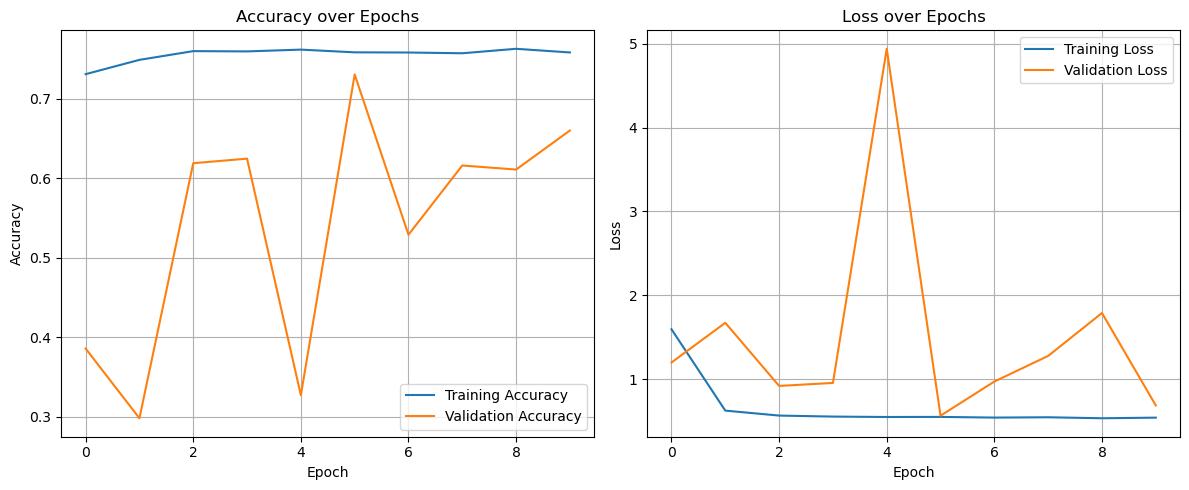

In [100]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_head.history['accuracy'], label='Training Accuracy')
plt.plot(history_head.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_head.history['loss'], label='Training Loss')
plt.plot(history_head.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [40]:
#MobileNetV2 model 1
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, BatchNormalization

num_classes = 3
img_size = (128, 128, 3)

# Load MobileNetV2 without top
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=img_size)

# Freeze early layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Start modifying the internal flow
x = base_model.output

# Add extra conv layer 
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

#  Pooling + classifier
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model6 = Model(inputs=base_model.input, outputs=outputs)

# Compile
model6.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 11s 1us/step


In [52]:
# Training the model
history6 = model6.fit(
    X_train_rgb, y_train_final,
    validation_data=(X_val_rgb, y_val),
    batch_size=64,
    epochs=10,
    shuffle=True
)

Epoch 1/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.7750 - loss: 0.4979 - val_accuracy: 0.5684 - val_loss: 4.0143
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.8882 - loss: 0.2693 - val_accuracy: 0.6172 - val_loss: 3.5554
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 191s 889ms/step - accuracy: 0.9298 - loss: 0.1758 - val_accuracy: 0.6411 - val_loss: 1.6733
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 200s 931ms/step - accuracy: 0.9558 - loss: 0.1152 - val_accuracy: 0.4801 - val_loss: 2.3062
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 205s 952ms/step - accuracy: 0.9717 - loss: 0.0803 - val_accuracy: 0.4182 - val_loss: 2.9009
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 185s 858ms/step - accuracy: 0.9747 - loss: 0.0704 - val_accuracy: 0.7946 - val_loss: 1.3001
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 174s 807ms/step - accuracy: 0.9770 - loss: 0.0650 - val_accuracy: 0.5719 - val_loss: 6.0310
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 175s 812ms/step - accuracy: 0.9839 - loss:

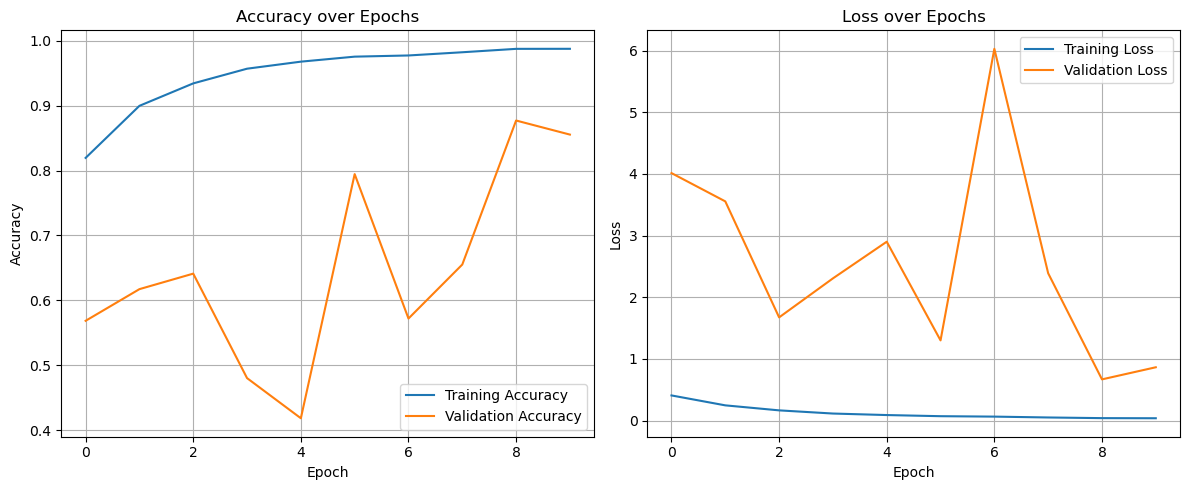

In [54]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history6.history['accuracy'], label='Training Accuracy')
plt.plot(history6.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history6.history['loss'], label='Training Loss')
plt.plot(history6.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 351ms/step
Confusion Matrix:
 [[554  85   0]
 [348 311   3]
 [  1  26  34]]


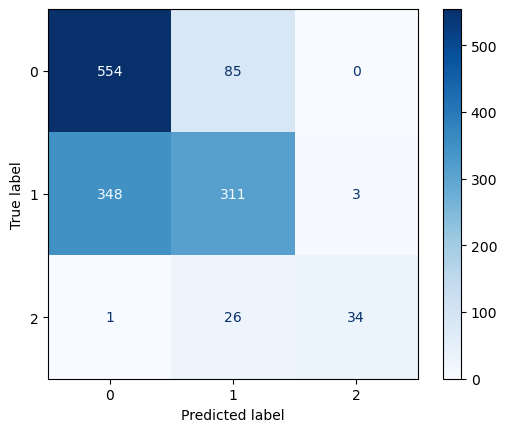

Classification Report:

              precision    recall  f1-score   support

           0     0.6135    0.8670    0.7185       639
           1     0.7370    0.4698    0.5738       662
           2     0.9189    0.5574    0.6939        61

    accuracy                         0.6601      1362
   macro avg     0.7565    0.6314    0.6621      1362
weighted avg     0.6872    0.6601    0.6471      1362



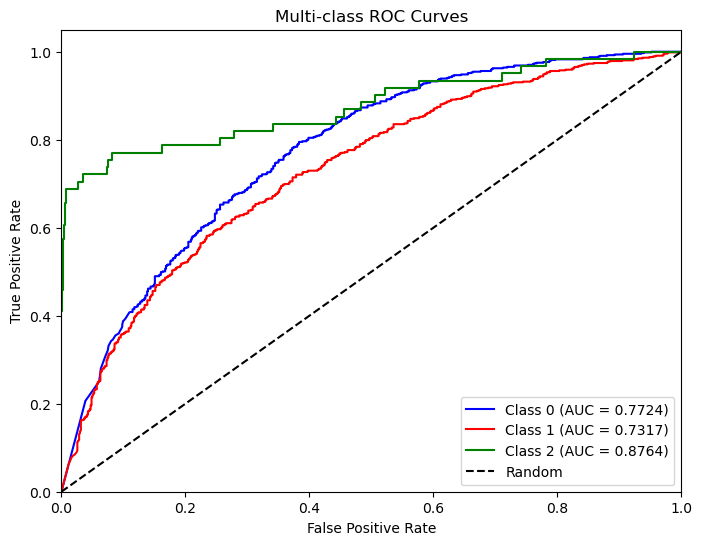

Macro AUC: 0.7935
Micro AUC: 0.8306


In [78]:
#MobileNetV2 model 1 confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np


# Predict on test set
y_pred_probs = model6.predict(X_test_rgb)              # predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)             # predicted class indices


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()


# Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))


# Multi-class ROC and AUC
## Binarize labels for ROC computation
y_test_oh = label_binarize(y_test, classes=np.arange(num_classes))  # shape (N, num_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_oh[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot per-class ROC curves
plt.figure(figsize=(8,6))
colors = ['blue', 'red', 'green']
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'Class {i} (AUC = {roc_auc[i]:.4f})')
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves')
plt.legend(loc='lower right')
plt.show()


# Macro and Micro AUC
from sklearn.metrics import roc_auc_score
macro_auc = roc_auc_score(y_test_oh, y_pred_probs, average='macro')
micro_auc = roc_auc_score(y_test_oh, y_pred_probs, average='micro')
print(f"Macro AUC: {macro_auc:.4f}")
print(f"Micro AUC: {micro_auc:.4f}")


In [60]:
#MobileNetV2 model 2 fine tuned 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Parameters
num_classes = 3
batch_size = 64
initial_lr = 1e-4
epochs = 15

# MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))

# Freeze early layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Add extra conv layer with BatchNorm + Dropout
x = base_model.output
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Global pooling + Dense head with L2 + BatchNorm + Dropout
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Create model
model7 = Model(inputs=base_model.input, outputs=outputs)

# Compile with sparse categorical crossentropy
optimizer = Adam(learning_rate=initial_lr)
model7.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#  Train new layers only
history7 = model7.fit(
    X_train_rgb, y_train_final,
    validation_data=(X_val_rgb, y_val),
    epochs=epochs,
    verbose=1
)


Epoch 1/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 196s 409ms/step - accuracy: 0.7360 - loss: 0.7332 - val_accuracy: 0.7585 - val_loss: 0.5710
Epoch 2/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 176s 408ms/step - accuracy: 0.8718 - loss: 0.3462 - val_accuracy: 0.7432 - val_loss: 0.7078
Epoch 3/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 167s 389ms/step - accuracy: 0.9363 - loss: 0.1826 - val_accuracy: 0.8574 - val_loss: 0.3914
Epoch 4/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 169s 392ms/step - accuracy: 0.9647 - loss: 0.1217 - val_accuracy: 0.8456 - val_loss: 0.4847
Epoch 5/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 176s 409ms/step - accuracy: 0.9752 - loss: 0.0875 - val_accuracy: 0.9349 - val_loss: 0.2053
Epoch 6/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 172s 401ms/step - accuracy: 0.9784 - loss: 0.0765 - val_accuracy: 0.9413 - val_loss: 0.1914
Epoch 7/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 169s 394ms/step - accuracy: 0.9852 - loss: 0.0641 - val_accuracy: 0.8670 - val_loss: 0.4995
Epoch 8/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 175s 407ms/step - accuracy: 0.9891 -

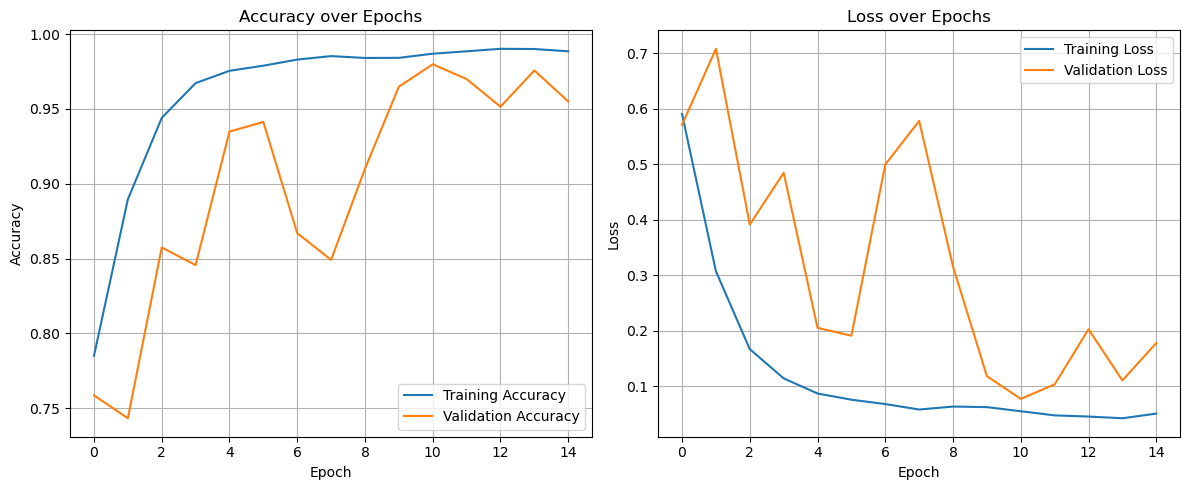

In [62]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history7.history['accuracy'], label='Training Accuracy')
plt.plot(history7.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history7.history['loss'], label='Training Loss')
plt.plot(history7.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

43/43 ━━━━━━━━━━━━━━━━━━━━ 31s 616ms/step
Confusion Matrix:
 [[455 184   0]
 [ 79 582   1]
 [  0  32  29]]


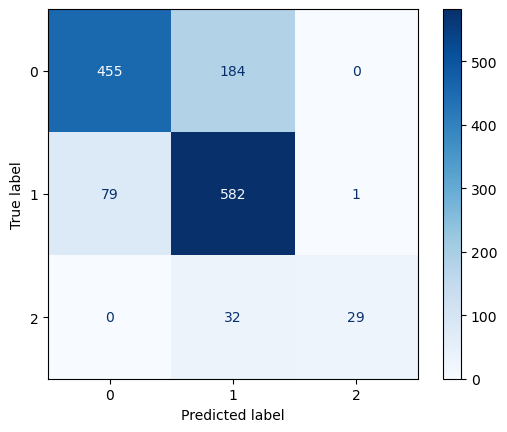

Classification Report:

              precision    recall  f1-score   support

           0     0.8521    0.7121    0.7758       639
           1     0.7293    0.8792    0.7973       662
           2     0.9667    0.4754    0.6374        61

    accuracy                         0.7827      1362
   macro avg     0.8493    0.6889    0.7368      1362
weighted avg     0.7975    0.7827    0.7800      1362



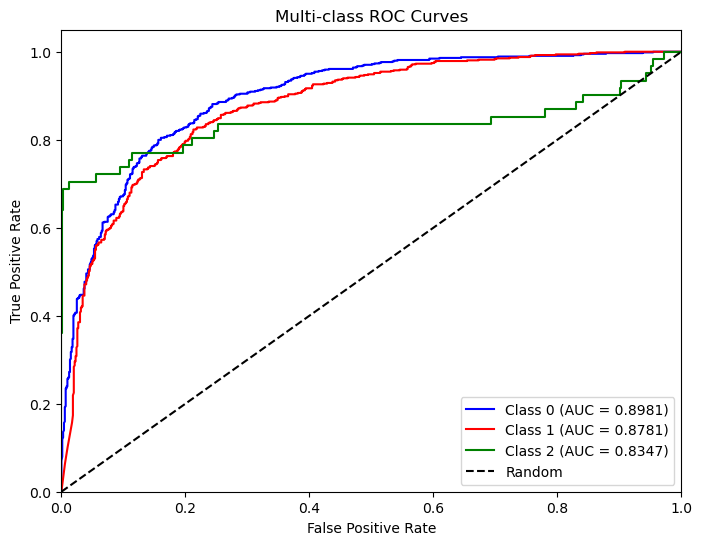

Macro AUC: 0.8703
Micro AUC: 0.9224


In [76]:
#Confusion matrix and classification report for MobileNetV2 model 2 fine tuned
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Predict on test set
y_pred_probs = model7.predict(X_test_rgb)              # predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)             # predicted class indices

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

# Multi-class ROC and AUC
# Binarize labels for ROC computation
y_test_oh = label_binarize(y_test, classes=np.arange(num_classes))  # shape (N, num_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_oh[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot per-class ROC curves
plt.figure(figsize=(8,6))
colors = ['blue', 'red', 'green']
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'Class {i} (AUC = {roc_auc[i]:.4f})')
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves')
plt.legend(loc='lower right')
plt.show()

# Macro and Micro AUC
from sklearn.metrics import roc_auc_score
macro_auc = roc_auc_score(y_test_oh, y_pred_probs, average='macro')
micro_auc = roc_auc_score(y_test_oh, y_pred_probs, average='micro')
print(f"Macro AUC: {macro_auc:.4f}")
print(f"Micro AUC: {micro_auc:.4f}")


In [66]:
#MobileNetV2 model 2 fine tuned - freezed the last 20 layers of base

model7_tuned = Model(inputs=base_model.input, outputs=outputs)
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Smaller LR for fine-tuning
optimizer_fine = Adam(learning_rate=1e-5)
model7_tuned.compile(optimizer=optimizer_fine, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history7_tuned = model7_tuned.fit(
    X_train_rgb, y_train_final,
    validation_data=(X_val_rgb, y_val),
    epochs=epochs,
    verbose=1
)


Epoch 1/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 442s 957ms/step - accuracy: 0.9942 - loss: 0.0354 - val_accuracy: 0.9898 - val_loss: 0.0534
Epoch 2/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 391s 910ms/step - accuracy: 0.9988 - loss: 0.0206 - val_accuracy: 0.9955 - val_loss: 0.0387
Epoch 3/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 395s 919ms/step - accuracy: 0.9993 - loss: 0.0197 - val_accuracy: 0.9962 - val_loss: 0.0337
Epoch 4/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 382s 888ms/step - accuracy: 0.9991 - loss: 0.0192 - val_accuracy: 0.9981 - val_loss: 0.0312
Epoch 5/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 375s 872ms/step - accuracy: 0.9992 - loss: 0.0188 - val_accuracy: 0.9974 - val_loss: 0.0333
Epoch 6/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 376s 857ms/step - accuracy: 0.9986 - loss: 0.0192 - val_accuracy: 0.9981 - val_loss: 0.0311
Epoch 7/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 366s 851ms/step - accuracy: 0.9994 - loss: 0.0182 - val_accuracy: 0.9987 - val_loss: 0.0298
Epoch 8/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 367s 854ms/step - accuracy: 0.9994 -

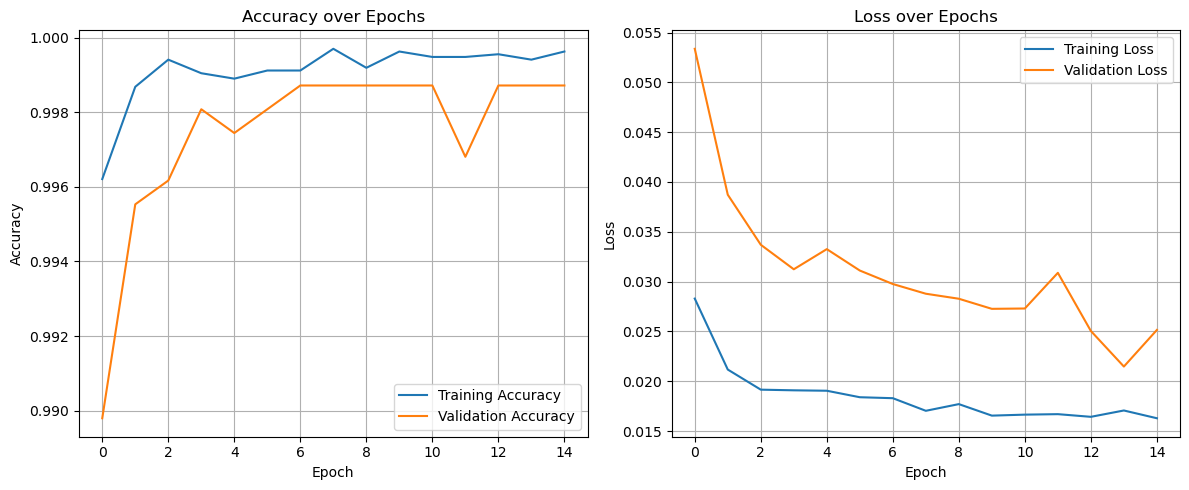

In [68]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history7_tuned.history['accuracy'], label='Training Accuracy')
plt.plot(history7_tuned.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history7_tuned.history['loss'], label='Training Loss')
plt.plot(history7_tuned.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 490ms/step
Confusion Matrix:
 [[455 184   0]
 [ 79 582   1]
 [  0  32  29]]


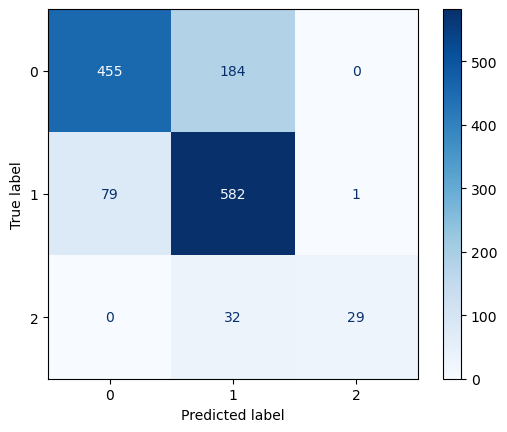

Classification Report:

              precision    recall  f1-score   support

           0     0.8521    0.7121    0.7758       639
           1     0.7293    0.8792    0.7973       662
           2     0.9667    0.4754    0.6374        61

    accuracy                         0.7827      1362
   macro avg     0.8493    0.6889    0.7368      1362
weighted avg     0.7975    0.7827    0.7800      1362



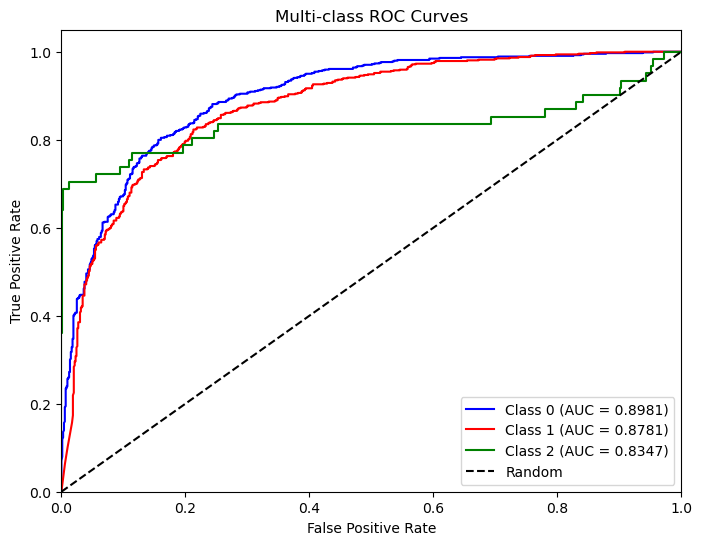

Macro AUC: 0.8703
Micro AUC: 0.9224


In [74]:
#Classification report and confusion matrix for the MobileNetv2 model 2 fine tuned- freeze last 20 layers
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Predict on test set
y_pred_probs = model7_tuned.predict(X_test_rgb)              # predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)             # predicted class indices


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()


# Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))


# Multi-class ROC and AUC
# Binarize labels for ROC computation
y_test_oh = label_binarize(y_test, classes=np.arange(num_classes))  # shape (N, num_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_oh[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot per-class ROC curves
plt.figure(figsize=(8,6))
colors = ['blue', 'red', 'green']
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'Class {i} (AUC = {roc_auc[i]:.4f})')
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves')
plt.legend(loc='lower right')
plt.show()


# Macro and Micro AUC
from sklearn.metrics import roc_auc_score
macro_auc = roc_auc_score(y_test_oh, y_pred_probs, average='macro')
micro_auc = roc_auc_score(y_test_oh, y_pred_probs, average='micro')
print(f"Macro AUC: {macro_auc:.4f}")
print(f"Micro AUC: {micro_auc:.4f}")
